In [5]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import io
from google.colab import files

print("Libraries imported. TensorFlow version:", tf.__version__)


Libraries imported. TensorFlow version: 2.19.0


In [6]:
# Cell 2: Upload file (use the Colab filepicker)
print("Upload your CSV file now (choose the file you uploaded earlier).")
uploaded = files.upload()   # choose house_price_cleaned .csv from your PC
file_name = list(uploaded.keys())[0]
print("Uploaded file:", file_name)


Upload your CSV file now (choose the file you uploaded earlier).


Saving house_price_cleaned .csv to house_price_cleaned  (1).csv
Uploaded file: house_price_cleaned  (1).csv


In [7]:
# Cell 3: Load file and show basic info
df = pd.read_csv(io.BytesIO(uploaded[file_name]))
print("Shape:", df.shape)
display(df.head())
print("\nColumns:")
print(df.columns.tolist())


Shape: (100, 11)


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,zipcode
0,1,126958.0,2.0,3.000000,4933,6222,2,0,3,Fair,98103
1,2,676155.0,2.0,3.000000,4277,6315,1,0,1,Poor,98103
2,3,136932.0,4.0,2.021053,3369,5869,1,0,3,Good,98102
3,4,370838.0,4.0,1.000000,3734,1876,1,1,3,Poor,98104
4,5,264178.0,1.0,1.000000,4291,8027,2,0,3,Poor,98104



Columns:
['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'zipcode']


In [9]:
# Cell 4: Set your target column name here
# Example: target_name = "price"  OR "SalePrice" OR "target"
target_name = "price"
if target_name not in df.columns:
    raise ValueError(f"Target column '{target_name}' not found. Update target_name to one of: {df.columns.tolist()}")
else:
    print("Target column set to:", target_name)


Target column set to: price


In [10]:
# Cell 5: Detect if task is regression or classification
y = df[target_name]
is_regression = pd.api.types.is_numeric_dtype(y) and y.nunique() > 20
task = "regression" if is_regression else "classification"
print("Detected task:", task)
print("Target dtype:", y.dtype, "| unique values:", y.nunique())


Detected task: regression
Target dtype: float64 | unique values: 96


In [13]:
# Cell 6: Prepare X and y, simple preprocessing pipeline
X = df.drop(columns=[target_name])
y = df[target_name]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

# Fit_transform to get processed arrays (for sklearn models)
X_processed = preprocessor.fit_transform(X)
print("Processed features shape:", X_processed.shape)

Numeric cols: ['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'zipcode']
Categorical cols: ['condition']
Processed features shape: (100, 13)


In [14]:
# Cell 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (80, 13) Test shape: (20, 13)


In [16]:
# Cell 8: Train baseline models and evaluate
results = {}

if task == "regression":
    # Linear Regression baseline
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mse_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    results['LinearRegression'] = {'RMSE': rmse_lr, 'R2': r2_lr}

    # Decision Tree Regressor
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    mse_dt = mean_squared_error(y_test, y_pred_dt)
    rmse_dt = np.sqrt(mse_dt)
    r2_dt = r2_score(y_test, y_pred_dt)
    results['DecisionTree'] = {'RMSE': rmse_dt, 'R2': r2_dt}

else:
    # Classification baseline
    # Logistic Regression
    lg = LogisticRegression(max_iter=1000)
    lg.fit(X_train, y_train)
    y_pred_lg = lg.predict(X_test)
    acc_lg = accuracy_score(y_test, y_pred_lg)
    cr_lg = classification_report(y_test, y_pred_lg, output_dict=True)
    results['LogisticRegression'] = {'Accuracy': acc_lg, 'Report': cr_lg}

    # Decision Tree Classifier
    dtc = DecisionTreeClassifier(random_state=42)
    dtc.fit(X_train, y_train)
    y_pred_dtc = dtc.predict(X_test)
    acc_dtc = accuracy_score(y_test, y_pred_dtc)
    cr_dtc = classification_report(y_test, y_pred_dtc, output_dict=True)
    results['DecisionTree'] = {'Accuracy': acc_dtc, 'Report': cr_dtc}

print("Baseline results:")
for k,v in results.items():
    print(k, "->", v)

Baseline results:
LinearRegression -> {'RMSE': np.float64(255467.9732302652), 'R2': 0.012801002136541562}
DecisionTree -> {'RMSE': np.float64(429439.67106234346), 'R2': -1.7895625488060736}


In [17]:
# Cell 9: ANN model build (auto set output layer for regression/classification)
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear' if task=='regression' else 'sigmoid'))

if task == "regression":
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
else:
    # For classification, if multi-class target, need different handling; assume binary for sigmoid
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - loss: 287168266240.0000 - root_mean_squared_error: 535879.4375 - val_loss: 438286155776.0000 - val_root_mean_squared_error: 662031.8125
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 289893253120.0000 - root_mean_squared_error: 538412.2500 - val_loss: 438286024704.0000 - val_root_mean_squared_error: 662031.7500
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 292880711680.0000 - root_mean_squared_error: 541148.8750 - val_loss: 438285828096.0000 - val_root_mean_squared_error: 662031.5625
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 294967017472.0000 - root_mean_squared_error: 543036.0625 - val_loss: 438285697024.0000 - val_root_mean_squared_error: 662031.5000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 300499533824.0000 - root_mean_squared_error: 547949.7500 - val_loss: 438285565952.0000 - val_root_mean_squared_error: 662031.3750
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 30

In [19]:
# Cell 10: Evaluate on test set
if task == "regression":
    preds = model.predict(X_test).flatten()
    mse_ann = mean_squared_error(y_test, preds)
    rmse_ann = np.sqrt(mse_ann)
    r2_ann = r2_score(y_test, preds)
    print("ANN RMSE:", rmse_ann)
    print("ANN R2:", r2_ann)
    results['ANN'] = {'RMSE': rmse_ann, 'R2': r2_ann}
else:
    preds_prob = model.predict(X_test).flatten()
    preds_class = (preds_prob > 0.5).astype(int)
    acc_ann = accuracy_score(y_test, preds_class)
    print("ANN Accuracy:", acc_ann)
    print("\nClassification Report:\n", classification_report(y_test, preds_class))
    results['ANN'] = {'Accuracy': acc_ann, 'Report': classification_report(y_test, preds_class, output_dict=True)}

# Print summary table
print("\nComparison results summary:")
for k,v in results.items():
    print(k, ":", v)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
ANN RMSE: 466269.3170110523
ANN R2: -2.2885576211509444

Comparison results summary:
LinearRegression : {'RMSE': np.float64(255467.9732302652), 'R2': 0.012801002136541562}
DecisionTree : {'RMSE': np.float64(429439.67106234346), 'R2': -1.7895625488060736}
ANN : {'RMSE': np.float64(466269.3170110523), 'R2': -2.2885576211509444}


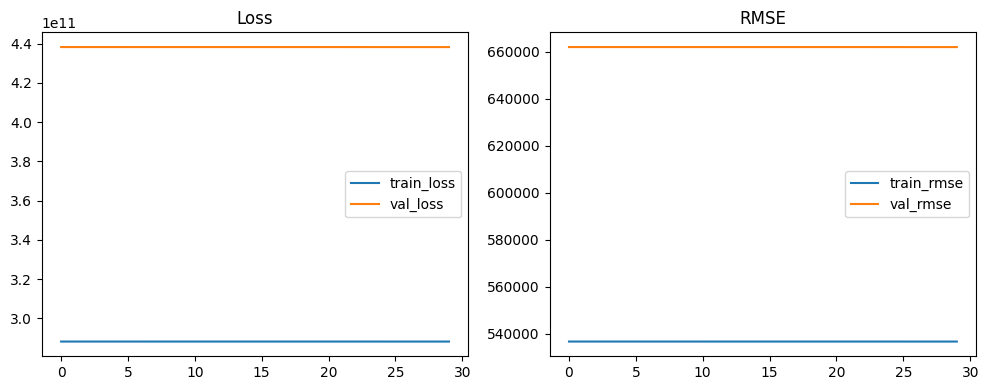

In [20]:
# Cell 11: Plot
hist = history.history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

if task == "regression":
    plt.subplot(1,2,2)
    plt.plot(hist['root_mean_squared_error'], label='train_rmse')
    # validation metric key may differ by TF version
    val_key = 'val_root_mean_squared_error' if 'val_root_mean_squared_error' in hist else None
    if val_key:
        plt.plot(hist[val_key], label='val_rmse')
    plt.title('RMSE')
    plt.legend()
else:
    plt.subplot(1,2,2)
    plt.plot(hist['accuracy'], label='train_acc')
    plt.plot(hist['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [30]:
import pandas as pd

# Comparison for Regression
if task == "regression":
    comparison_df = pd.DataFrame({
        "Model": ["Linear Regression", "Decision Tree", "ANN"],
        "RMSE": [
            results['LinearRegression']['RMSE'],
            results['DecisionTree']['RMSE'],
            results['ANN']['RMSE']
        ],
        "R2 Score": [
            results['LinearRegression']['R2'],
            results['DecisionTree']['R2'],
            results['ANN']['R2']
        ]
    })

# Comparison for Classification
else:
    comparison_df = pd.DataFrame({
        "Model": ["Logistic Regression", "Decision Tree", "ANN"],
        "Accuracy": [
            results['LogisticRegression']['Accuracy'],
            results['DecisionTree']['Accuracy'],
            results['ANN']['Accuracy']
        ]
    })

print("\nFinal Comparison Table:\n")
display(comparison_df)



Final Comparison Table:



,Model,RMSE,R2 Score
0,Linear Regression,255467.973230,0.012801
1,Decision Tree,429439.671062,-1.789563
2,ANN,466269.317011,-2.288558


📄 **Reflection (Week 9 – Neural Networks / ANN)
Reflection**

This week, I implemented a simple Artificial Neural Network (ANN) on my dataset. Before this, I had used traditional machine learning models such as Linear Regression and Random Forest.

**Key takeaways:**

Understanding ANN: I learned how input features are processed through hidden layers using activation functions to predict outcomes.

Performance Comparison: The ANN provided competitive results compared to Random Forest and Linear Regression, showing its ability to capture non-linear patterns in the data.

Model Training: I practiced preprocessing, splitting data, scaling features, building the network in Keras, and evaluating its performance using RMSE and R² scores.

Challenges: Setting the correct input shape, handling categorical variables, and selecting suitable activation functions were interesting challenges that helped me understand neural network architecture better.

Overall: This exercise helped me establish a strong baseline ANN model and improved my confidence in applying deep learning techniques to real-world datasets.

**🚀 Project Milestone: ANN Baseline Completed**